In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_palette("pastel")

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier 

In [2]:
df = pd.read_csv('./Invistico_Airline.csv')

# strip whitespace in columns
df.columns = [col.replace(' ', '') for col in df.columns]
df.head()

,satisfaction,CustomerType,Age,TypeofTravel,Class,FlightDistance,Seatcomfort,Departure/Arrivaltimeconvenient,Foodanddrink,Gatelocation,...,Onlinesupport,EaseofOnlinebooking,On-boardservice,Legroomservice,Baggagehandling,Checkinservice,Cleanliness,Onlineboarding,DepartureDelayinMinutes,ArrivalDelayinMinutes
0,satisfied,Loyal Customer,65,Personal Travel,Eco,265,0,0,0,2,...,2,3,3,0,3,5,3,2,0,0.0
1,satisfied,Loyal Customer,47,Personal Travel,Business,2464,0,0,0,3,...,2,3,4,4,4,2,3,2,310,305.0
2,satisfied,Loyal Customer,15,Personal Travel,Eco,2138,0,0,0,3,...,2,2,3,3,4,4,4,2,0,0.0
3,satisfied,Loyal Customer,60,Personal Travel,Eco,623,0,0,0,3,...,3,1,1,0,1,4,1,3,0,0.0
4,satisfied,Loyal Customer,70,Personal Travel,Eco,354,0,0,0,3,...,4,2,2,0,2,4,2,5,0,0.0


# Investigate Data

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129880 entries, 0 to 129879
Data columns (total 22 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   satisfaction                     129880 non-null  object 
 1   CustomerType                     129880 non-null  object 
 2   Age                              129880 non-null  int64  
 3   TypeofTravel                     129880 non-null  object 
 4   Class                            129880 non-null  object 
 5   FlightDistance                   129880 non-null  int64  
 6   Seatcomfort                      129880 non-null  int64  
 7   Departure/Arrivaltimeconvenient  129880 non-null  int64  
 8   Foodanddrink                     129880 non-null  int64  
 9   Gatelocation                     129880 non-null  int64  
 10  Inflightwifiservice              129880 non-null  int64  
 11  Inflightentertainment            129880 non-null  int64  
 12  On

In [4]:
df.isna().sum()

satisfaction                         0
CustomerType                         0
Age                                  0
TypeofTravel                         0
Class                                0
FlightDistance                       0
Seatcomfort                          0
Departure/Arrivaltimeconvenient      0
Foodanddrink                         0
Gatelocation                         0
Inflightwifiservice                  0
Inflightentertainment                0
Onlinesupport                        0
EaseofOnlinebooking                  0
On-boardservice                      0
Legroomservice                       0
Baggagehandling                      0
Checkinservice                       0
Cleanliness                          0
Onlineboarding                       0
DepartureDelayinMinutes              0
ArrivalDelayinMinutes              393
dtype: int64

In [5]:
# there are a lot of null values for arrival delay, let's fill in these records with the median value
df.fillna(value = df.ArrivalDelayinMinutes.median(), inplace = True)

In [6]:
df.isna().sum()

satisfaction                       0
CustomerType                       0
Age                                0
TypeofTravel                       0
Class                              0
FlightDistance                     0
Seatcomfort                        0
Departure/Arrivaltimeconvenient    0
Foodanddrink                       0
Gatelocation                       0
Inflightwifiservice                0
Inflightentertainment              0
Onlinesupport                      0
EaseofOnlinebooking                0
On-boardservice                    0
Legroomservice                     0
Baggagehandling                    0
Checkinservice                     0
Cleanliness                        0
Onlineboarding                     0
DepartureDelayinMinutes            0
ArrivalDelayinMinutes              0
dtype: int64

In [7]:
# split dataframe into categorical and numeric variables
df_cat = df[['CustomerType', 'TypeofTravel', 'Class', 'satisfaction']].copy()
df_num = df.copy()
df_num.drop(labels = ['CustomerType', 'TypeofTravel', 'Class'], axis = 1, inplace = True)

In [8]:
df_cat.head()

,CustomerType,TypeofTravel,Class,satisfaction
0,Loyal Customer,Personal Travel,Eco,satisfied
1,Loyal Customer,Personal Travel,Business,satisfied
2,Loyal Customer,Personal Travel,Eco,satisfied
3,Loyal Customer,Personal Travel,Eco,satisfied
4,Loyal Customer,Personal Travel,Eco,satisfied


In [9]:
df_num.head()

,satisfaction,Age,FlightDistance,Seatcomfort,Departure/Arrivaltimeconvenient,Foodanddrink,Gatelocation,Inflightwifiservice,Inflightentertainment,Onlinesupport,EaseofOnlinebooking,On-boardservice,Legroomservice,Baggagehandling,Checkinservice,Cleanliness,Onlineboarding,DepartureDelayinMinutes,ArrivalDelayinMinutes
0,satisfied,65,265,0,0,0,2,2,4,2,3,3,0,3,5,3,2,0,0.0
1,satisfied,47,2464,0,0,0,3,0,2,2,3,4,4,4,2,3,2,310,305.0
2,satisfied,15,2138,0,0,0,3,2,0,2,2,3,3,4,4,4,2,0,0.0
3,satisfied,60,623,0,0,0,3,3,4,3,1,1,0,1,4,1,3,0,0.0
4,satisfied,70,354,0,0,0,3,4,3,4,2,2,0,2,4,2,5,0,0.0


In [10]:
df_num[df_num.DepartureDelayinMinutes>0].head(10)

,satisfaction,Age,FlightDistance,Seatcomfort,Departure/Arrivaltimeconvenient,Foodanddrink,Gatelocation,Inflightwifiservice,Inflightentertainment,Onlinesupport,EaseofOnlinebooking,On-boardservice,Legroomservice,Baggagehandling,Checkinservice,Cleanliness,Onlineboarding,DepartureDelayinMinutes,ArrivalDelayinMinutes
1,satisfied,47,2464,0,0,0,3,0,2,2,3,4,4,4,2,3,2,310,305.0
6,satisfied,66,227,0,0,0,3,2,5,5,5,5,0,5,5,5,3,17,15.0
9,satisfied,22,1556,0,0,0,3,2,0,2,2,2,4,5,3,4,2,30,26.0
10,satisfied,58,104,0,0,0,3,3,3,3,3,3,0,1,2,3,5,47,48.0
14,satisfied,47,84,0,1,0,1,5,2,1,5,5,0,5,2,5,2,40,48.0
16,satisfied,13,3693,0,1,0,2,4,0,4,4,4,4,1,3,1,4,5,0.0
27,satisfied,42,470,0,1,0,2,3,2,2,3,3,0,3,1,3,4,2,23.0
30,satisfied,62,2948,0,1,0,3,5,0,5,5,4,1,2,2,2,5,34,19.0
31,satisfied,21,2823,0,1,0,3,2,0,2,2,2,2,2,2,3,2,4,0.0
39,satisfied,31,2162,0,1,0,3,2,0,3,2,1,4,2,1,2,2,13,0.0


# Categoical Variable Exploration

In [11]:
df_cat.satisfaction.value_counts()

satisfied       71087
dissatisfied    58793
Name: satisfaction, dtype: int64

In [12]:
# transform satisfaction variable to 0s and 1s for analysis
df_cat.satisfaction = df_cat.satisfaction.replace({'satisfied': 1, 'dissatisfied': 0})

## Customer Type

In [13]:
df_cat.groupby('CustomerType').aggregate({'satisfaction': 'mean'})

,satisfaction
CustomerType,
Loyal Customer,0.616277
disloyal Customer,0.239697


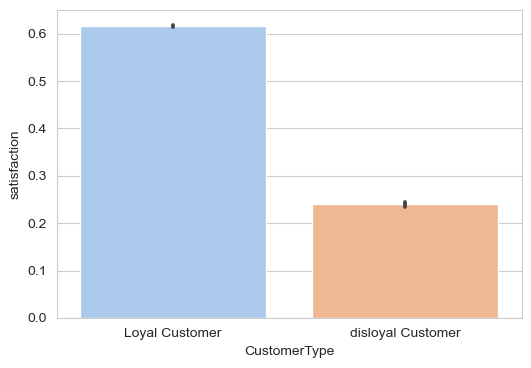

In [14]:
plt.figure(figsize = (6,4))
sns.barplot(data = df_cat, x = 'CustomerType', y = 'satisfaction')
plt.show()

## Type of Travel

In [15]:
df_cat.groupby('TypeofTravel').aggregate({'satisfaction': 'mean'})

,satisfaction
TypeofTravel,
Business travel,0.583724
Personal Travel,0.466096


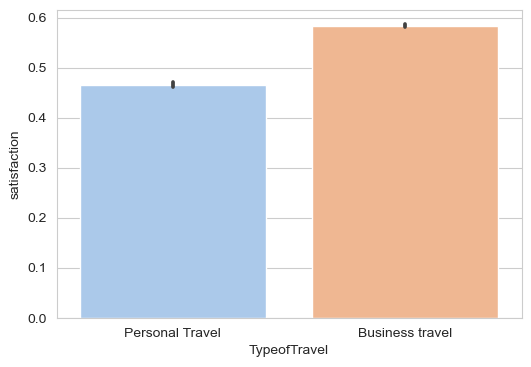

In [16]:
plt.figure(figsize = (6,4))
sns.barplot(data = df_cat, x = 'TypeofTravel', y = 'satisfaction')
plt.show()

## Class

In [17]:
df_cat.groupby('Class').aggregate({'satisfaction': 'mean'})

,satisfaction
Class,
Business,0.709379
Eco,0.393987
Eco Plus,0.427053


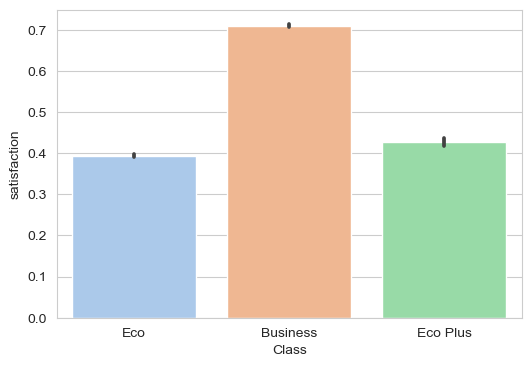

In [18]:
plt.figure(figsize = (6,4))
sns.barplot(data = df_cat, x = 'Class', y = 'satisfaction')
plt.show()

# Categorical Variable Conclusion

<ul>
    <li>
        <p style="font-size: 14px">
            <strong style="font-size: 16px">Customer Type:</strong>
            Loyal customers are satisfied ~62% of the time while disloyal customers are satisfied ~24% of the time.
        </p>
    </li>
    <li>
        <p style="font-size: 14px">
            <strong style="font-size: 16px">Type of Travel</strong>
            Passengers flying for "business" are more likely than customers who aren't flying for business.
        </p>
    </li>
    <li>
        <p style="font-size: 14px">
            <strong style="font-size: 16px">Class</strong>
            Business class customers are satisfied 71% of the time while non-business class customers are satisfied ~40% of the time.
        </p>
    </li>
</ul>

# Numerical Variable Exploration

In [19]:
# let's start by grouping variables by whether or not a customer is satisfied
# This way, we can quickly locate the more important independent variables

group = df_num.groupby('satisfaction').mean()
group

,Age,FlightDistance,Seatcomfort,Departure/Arrivaltimeconvenient,Foodanddrink,Gatelocation,Inflightwifiservice,Inflightentertainment,Onlinesupport,EaseofOnlinebooking,On-boardservice,Legroomservice,Baggagehandling,Checkinservice,Cleanliness,Onlineboarding,DepartureDelayinMinutes,ArrivalDelayinMinutes
satisfaction,,,,,,,,,,,,,,,,,,
dissatisfied,37.466671,2025.709234,2.467335,3.016686,2.660419,3.007756,2.919854,2.608644,2.959213,2.852261,2.973126,3.052625,3.364601,2.971850,3.377324,2.869695,17.807749,18.445427
satisfied,41.050051,1944.770281,3.145653,2.969108,3.010438,2.976086,3.521460,4.024308,3.983260,3.984751,3.871946,3.844247,3.969488,3.645955,3.977394,3.751966,12.154768,12.233503


There are a few variables that immediately seem to jump out here.  
<ul>
    <li>
        Age
    </li>
    <li>
        In Flight Wifi Service
    </li>
    <li>
        Departure Delay in Minutes
    </li>
</ul>

Let's explore these variables visually to see these differences.

## Age

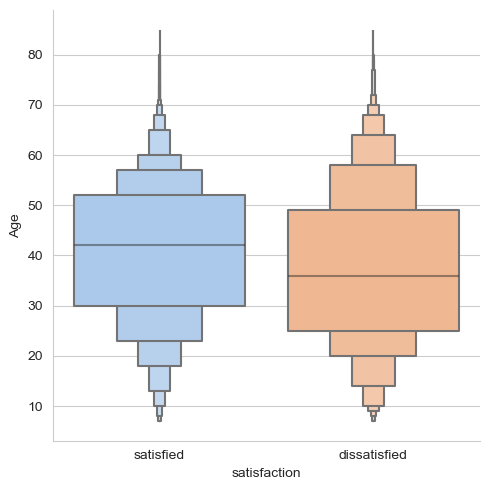

In [20]:
sns.catplot(data = df, x = 'satisfaction', y = 'Age', kind = 'boxen')
plt.show()

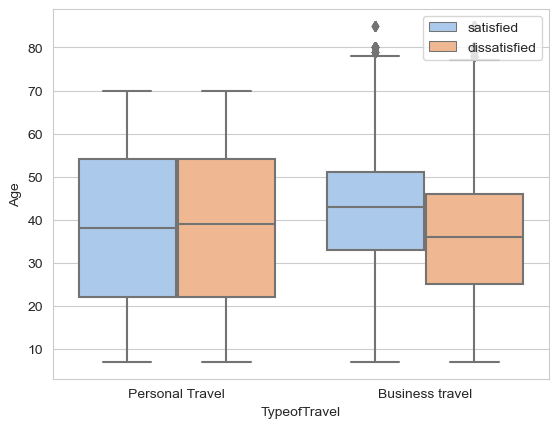

In [21]:
sns.boxplot(data = df, x = 'TypeofTravel', y = 'Age', hue = 'satisfaction')
plt.legend(loc = 'upper right')
plt.show()

## In Flight Wifi Service

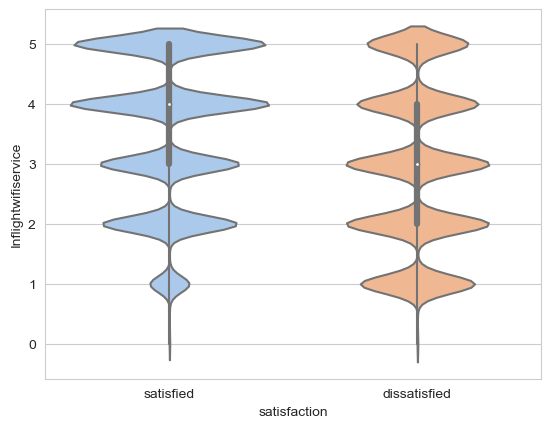

In [22]:
sns.violinplot(data = df, x = 'satisfaction', y = 'Inflightwifiservice')
plt.show()

In [23]:
wifi_group = df.groupby(['satisfaction', 'Inflightwifiservice']).aggregate({'CustomerType': 'count'})\
    .rename(columns = {'CustomerType': 'Count'})


# reorient dataframe for easier calculation of percentages
wifi_group = wifi_group.unstack().transpose()
wifi_group.index = np.arange(0,6)

# calculate percentage
wifi_group['PercentageOfDissatisfied'] = wifi_group.dissatisfied / wifi_group.dissatisfied.sum()
wifi_group['PercentageOfSatisified'] = wifi_group.satisfied / wifi_group.satisfied.sum()

wifi_group

satisfaction,dissatisfied,satisfied,PercentageOfDissatisfied,PercentageOfSatisified
0,73,59,0.001242,0.000830
1,10762,3949,0.183049,0.055552
2,13464,13581,0.229007,0.191048
3,13535,14067,0.230214,0.197884
4,11423,20137,0.194292,0.283273
5,9536,19294,0.162196,0.271414


## Departure Delay

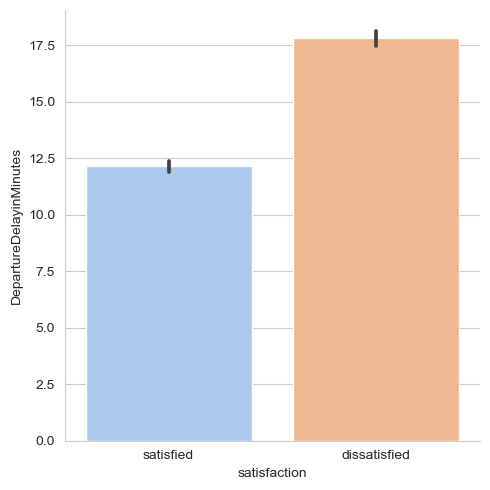

In [24]:
sns.catplot(data = df, x = 'satisfaction', y = 'DepartureDelayinMinutes', kind = 'bar')
plt.show()

# Numeric Variable Conclusion

<ul>
    <li>
        <p style="font-size: 14px">
            <strong style="font-size: 16px">Age:</strong>
            The median age of a satisfied customer is 41 while the median age of a dissatisfied customer is 37.
        </p>
    </li>
    <li>
        <p style="font-size: 14px">
            <strong style="font-size: 16px">In flight Wifi service: </strong>
            27% of satisfied customers rated the in flight wifi service as a 5 while only
            16% of dissatisfied customers rated the in flight wifi service as a 5.
        </p>
    </li>
    <li>
        <p style="font-size: 14px">
            <strong style="font-size: 16px">Departure Delay in Minutes: </strong>
            A dissatisfied customer is delayed by 5 more minutes on average than a satisfied customer.
        </p>
    </li>
</ul>

# Feature Selection

In [25]:
def perm_fun(df, col, len_a):
    a = df.sample(n = len_a, replace = False)
    b = df[~df.index.isin(a.index)]
    
    return a[col].mean() - b[col].mean()

In [26]:
def generate_diffs_and_graph(col, len_a, df, pos_col, neg_col):
    # generated permuted differences
    actual_diff = group.loc[pos_col][col] - group.loc[neg_col][col]
    diffs = [perm_fun(df, col, len_a) for _ in range(1000)]
    
    # plot permuted differences and actual difference
    plt.figure(figsize = (5,4))
    sns.histplot(diffs)
    plt.axvline(x = actual_diff, color = 'red')
    plt.title(f"Perm Test (statistical significance) for {col}")
    plt.show()

    # calculate and print p-val for statistical significance test
    p_val = [np.abs(diff) > np.abs(actual_diff) for diff in diffs]
    p_val = np.array(p_val).mean()
    print("p-val:", p_val)
    
    return p_val

## Significance Testing

Let's try to find out which independent variables are significantly different from each other based on customer
satisfaction.

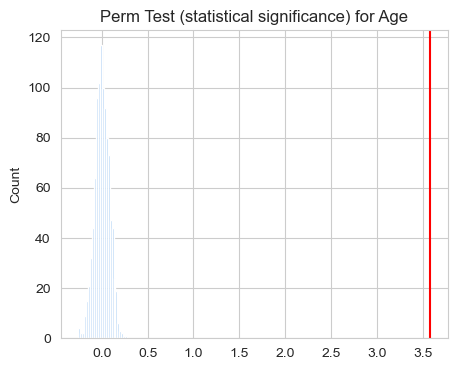

p-val: 0.0


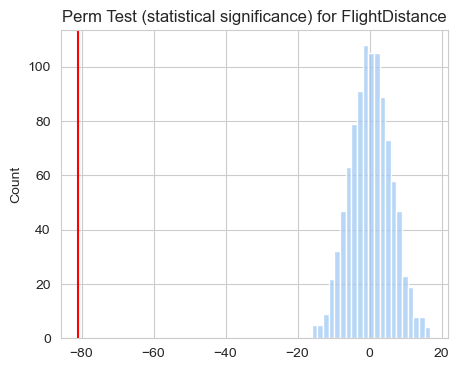

p-val: 0.0


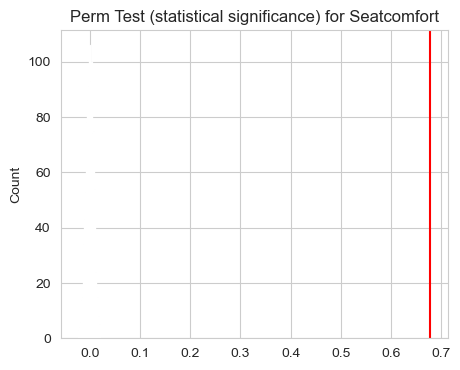

p-val: 0.0


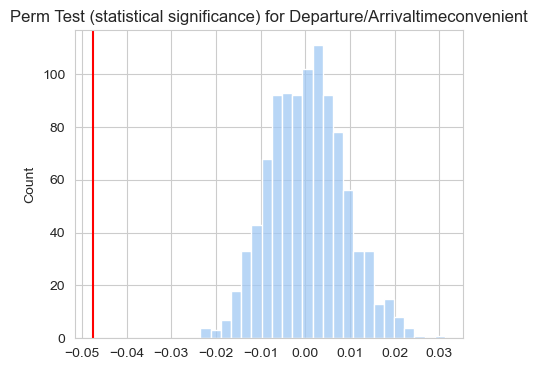

p-val: 0.0


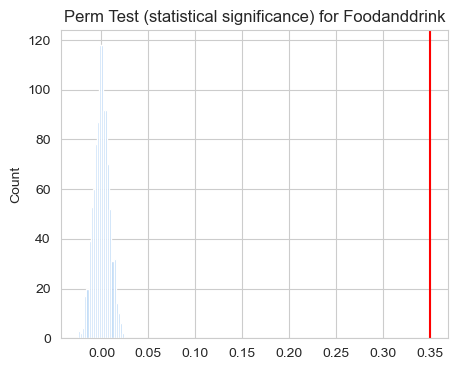

p-val: 0.0


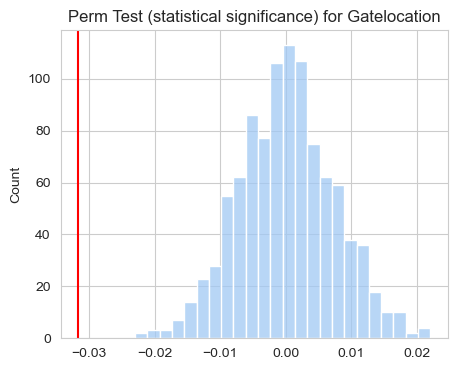

p-val: 0.0


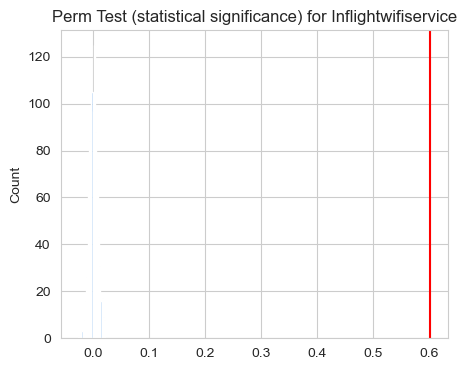

p-val: 0.0


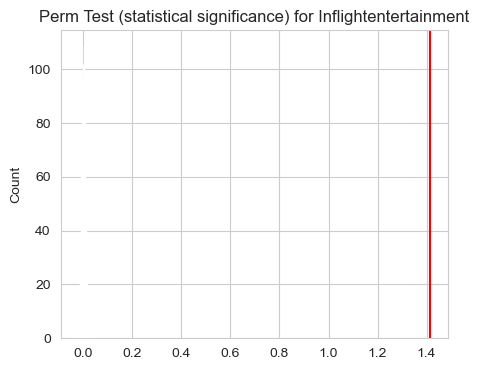

p-val: 0.0


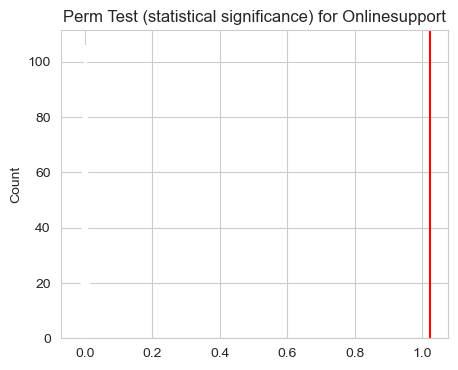

p-val: 0.0


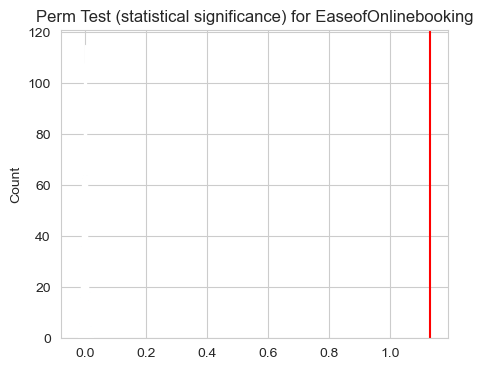

p-val: 0.0


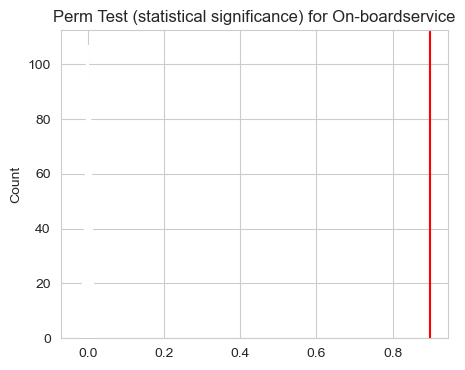

p-val: 0.0


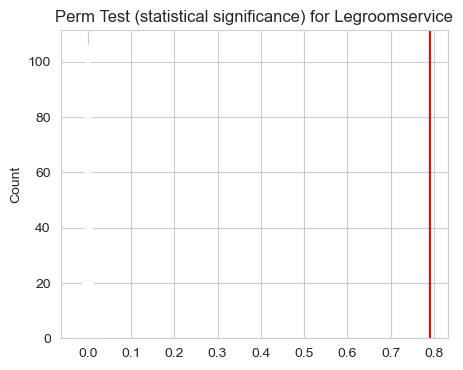

p-val: 0.0


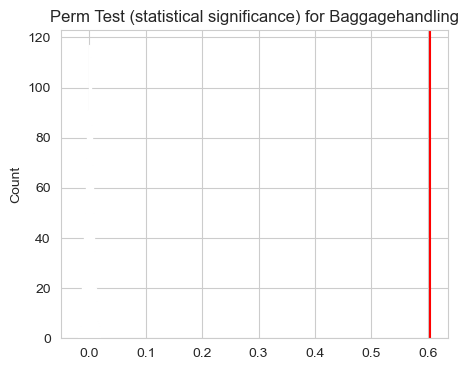

p-val: 0.0


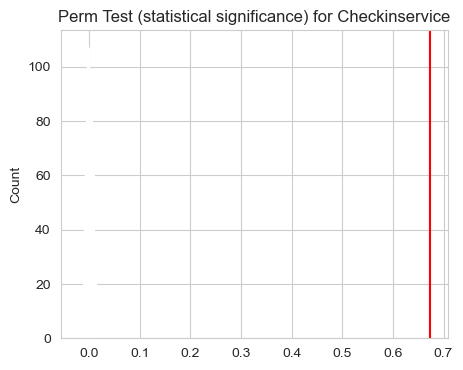

p-val: 0.0


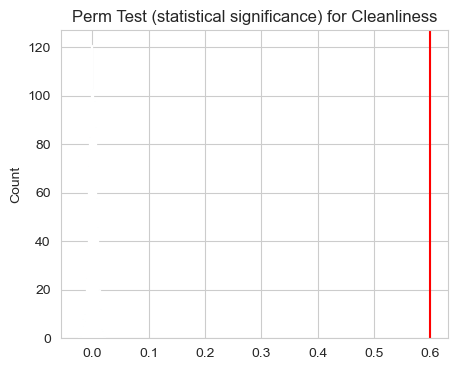

p-val: 0.0


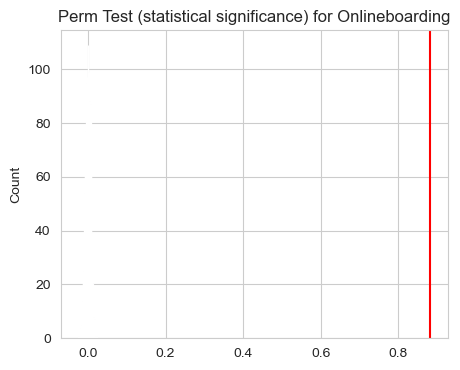

p-val: 0.0


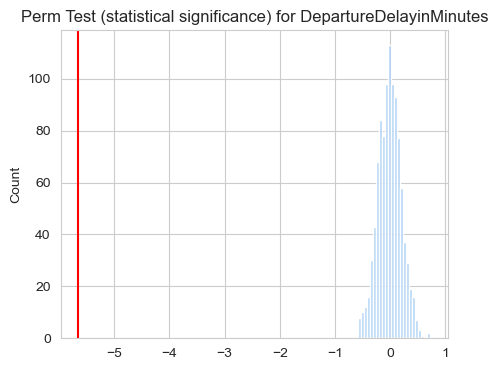

p-val: 0.0


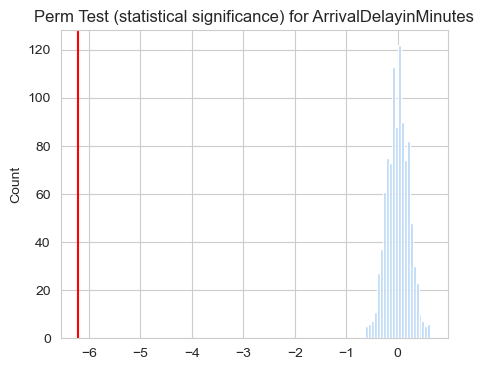

p-val: 0.0


In [27]:
significant_vars = []
len_a = df.satisfaction.value_counts().loc['satisfied']

for col in group.columns:
    p_val = generate_diffs_and_graph(col, len_a, df, 'satisfied', 'dissatisfied')
    if (p_val <= .05):
        significant_vars.append(col)

In [28]:
cat_vars = ['CustomerType', 'TypeofTravel', 'Class']

significant_vars # numerical variables

['Age',
 'FlightDistance',
 'Seatcomfort',
 'Departure/Arrivaltimeconvenient',
 'Foodanddrink',
 'Gatelocation',
 'Inflightwifiservice',
 'Inflightentertainment',
 'Onlinesupport',
 'EaseofOnlinebooking',
 'On-boardservice',
 'Legroomservice',
 'Baggagehandling',
 'Checkinservice',
 'Cleanliness',
 'Onlineboarding',
 'DepartureDelayinMinutes',
 'ArrivalDelayinMinutes']

# Create Pipelines

## Categorical Variable Pipeline

In [29]:
loan_cat = df[cat_vars]

cat_pipeline = Pipeline([
    ('categorical encoder', OneHotEncoder()) # get one hot values
])

loan_cat_tr = cat_pipeline.fit_transform(loan_cat)
loan_cat_tr = loan_cat_tr.toarray()
loan_cat_tr

array([[1., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 1., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 0., 1., 0.]])

## Numeric Variable Pipeline

In [30]:
df_num.drop(labels = ['satisfaction'], axis = 1)

,Age,FlightDistance,Seatcomfort,Departure/Arrivaltimeconvenient,Foodanddrink,Gatelocation,Inflightwifiservice,Inflightentertainment,Onlinesupport,EaseofOnlinebooking,On-boardservice,Legroomservice,Baggagehandling,Checkinservice,Cleanliness,Onlineboarding,DepartureDelayinMinutes,ArrivalDelayinMinutes
0,65,265,0,0,0,2,2,4,2,3,3,0,3,5,3,2,0,0.0
1,47,2464,0,0,0,3,0,2,2,3,4,4,4,2,3,2,310,305.0
2,15,2138,0,0,0,3,2,0,2,2,3,3,4,4,4,2,0,0.0
3,60,623,0,0,0,3,3,4,3,1,1,0,1,4,1,3,0,0.0
4,70,354,0,0,0,3,4,3,4,2,2,0,2,4,2,5,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129875,29,1731,5,5,5,3,2,5,2,2,3,3,4,4,4,2,0,0.0
129876,63,2087,2,3,2,4,2,1,1,3,2,3,3,1,2,1,174,172.0
129877,69,2320,3,0,3,3,3,2,2,4,4,3,4,2,3,2,155,163.0
129878,66,2450,3,2,3,2,3,2,2,3,3,2,3,2,1,2,193,205.0


In [31]:
numeric = df_num[significant_vars]

num_pipeline = Pipeline([
    ('scale', StandardScaler())
])
numeric_tr = num_pipeline.fit_transform(numeric)
numeric_tr

array([[ 1.69135082, -1.6711027 , -2.03779055, ..., -1.04148541,
        -0.38648106, -0.39164371],
       [ 0.50081965,  0.46985247, -2.03779055, ..., -1.04148541,
         7.75620407,  7.54771421],
       [-1.61568021,  0.15245757, -2.03779055, ..., -1.04148541,
        -0.38648106, -0.39164371],
       ...,
       [ 1.9559133 ,  0.32965349,  0.11586891, ..., -1.04148541,
         3.6848615 ,  3.85135741],
       [ 1.75749144,  0.45622201,  0.11586891, ..., -1.04148541,
         4.6829971 ,  4.94464604],
       [-0.09444593,  2.26420462,  0.11586891, ..., -0.27149028,
         4.47286329,  4.45006309]])

## Full Pipeline


In [32]:
num_columns = significant_vars # list of num column names
cat_columns = cat_vars # list of cat column names

full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_columns),
    ('cat', cat_pipeline, cat_columns)
])

data_prepared = full_pipeline.fit_transform(df)
data_prepared

array([[ 1.69135082, -1.6711027 , -2.03779055, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.50081965,  0.46985247, -2.03779055, ...,  1.        ,
         0.        ,  0.        ],
       [-1.61568021,  0.15245757, -2.03779055, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [ 1.9559133 ,  0.32965349,  0.11586891, ...,  0.        ,
         1.        ,  0.        ],
       [ 1.75749144,  0.45622201,  0.11586891, ...,  0.        ,
         1.        ,  0.        ],
       [-0.09444593,  2.26420462,  0.11586891, ...,  0.        ,
         1.        ,  0.        ]])

# Machine Learning Model

In [33]:
X = data_prepared
y = df['satisfaction'].replace({'satisfied': 1, 'dissatisfied': 0})

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = .8)

xgb = XGBClassifier(n_estimators = 100, max_depth = 10, gamma = 10, learning_rate = .1)

In [34]:
xgb.fit(X, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=10, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [35]:
predictions = xgb.predict(X_test)

print("Accuracy:", accuracy_score(y_test, predictions))
print("Precision:", precision_score(y_test, predictions))
print("Recall:", recall_score(y_test, predictions))

Accuracy: 0.9625038497074222
Precision: 0.9761973248957284
Recall: 0.954775636517091


## Hypertune Parameters using Cross-Validation

In [36]:
# perform grid search to tune hyperparameters
params = {
    "n_estimators": [50, 100, 200],
    "max_depth": [4, 6],
    "gamma": [1, 5],
    "learning_rate": [.01, .05]
}

xgb = XGBClassifier()

grid = GridSearchCV(xgb, param_grid = params)
grid.fit(X_train, y_train)

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_b...e,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_chil

In [37]:
grid.best_params_

{'gamma': 5, 'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 200}

In [38]:
# retrain model with the hypertuned parameters
tuned_model = XGBClassifier(n_estimators = grid.best_params_["max_depth"], max_depth = grid.best_params_["n_estimators"],
                      gamma = grid.best_params_["gamma"], learning_rate = grid.best_params_["learning_rate"])
tuned_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=5, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=200, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=6, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [40]:
# see how important each feature is
features = num_columns + cat_columns

list(zip(features, tuned_model.feature_importances_))

[('Age', 0.0037608414),
 ('FlightDistance', 0.0030993905),
 ('Seatcomfort', 0.08310335),
 ('Departure/Arrivaltimeconvenient', 0.009053487),
 ('Foodanddrink', 0.010051852),
 ('Gatelocation', 0.011815143),
 ('Inflightwifiservice', 0.004839873),
 ('Inflightentertainment', 0.61095726),
 ('Onlinesupport', 0.010953027),
 ('EaseofOnlinebooking', 0.08828614),
 ('On-boardservice', 0.004569741),
 ('Legroomservice', 0.011822096),
 ('Baggagehandling', 0.0047716396),
 ('Checkinservice', 0.014460708),
 ('Cleanliness', 0.007548748),
 ('Onlineboarding', 0.010249174),
 ('DepartureDelayinMinutes', 0.0038626958),
 ('ArrivalDelayinMinutes', 0.0049452884),
 ('CustomerType', 0.047842763),
 ('TypeofTravel', 0.0),
 ('Class', 0.011623895)]

In [41]:
predictions = tuned_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, predictions))
print("Precision:", precision_score(y_test, predictions))
print("Recall:", recall_score(y_test, predictions))

Accuracy: 0.9483369263935941
Precision: 0.9634321911891737
Recall: 0.9413419608946406
